# 日経平均株価 日足 メディアン統計

In [1]:
import sys
path_up = '..'
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf

from funcs.technical import calc_robust_bollinger

code = 'N225'
symbol = '^%s' % code
#symbol = 'USDJPY=X'
ticker = yf.Ticker(symbol)
df = ticker.history(period='1y', interval='1d')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-03-18 00:00:00+09:00,38960.988281,39769.109375,38935.468750,39740.441406,128700000,0.0,0.0
2024-03-19 00:00:00+09:00,39622.578125,40003.601562,39407.500000,40003.601562,134700000,0.0,0.0
2024-03-21 00:00:00+09:00,40511.550781,40823.320312,40452.191406,40815.660156,157200000,0.0,0.0
2024-03-22 00:00:00+09:00,40942.878906,41087.750000,40714.140625,40888.429688,136100000,0.0,0.0
2024-03-25 00:00:00+09:00,40798.960938,40837.179688,40414.121094,40414.121094,101500000,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-11 00:00:00+09:00,36584.371094,36793.109375,35987.128906,36793.109375,153600000,0.0,0.0
2025-03-12 00:00:00+09:00,36763.101562,36956.328125,36658.859375,36819.089844,128700000,0.0,0.0
2025-03-13 00:00:00+09:00,37081.640625,37326.269531,36776.941406,36790.031250,119300000,0.0,0.0


In [3]:
df0 = ticker.history(period='3y', interval='1d')
df0

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-03-18 00:00:00+09:00,26649.500000,26862.429688,26592.980469,26827.429688,108200000,0.0,0.0
2022-03-22 00:00:00+09:00,27091.320312,27284.470703,27076.330078,27224.109375,98000000,0.0,0.0
2022-03-23 00:00:00+09:00,27606.789062,28056.199219,27604.369141,28040.160156,88200000,0.0,0.0
2022-03-24 00:00:00+09:00,27693.769531,28110.390625,27624.619141,28110.390625,71600000,0.0,0.0
2022-03-25 00:00:00+09:00,28338.810547,28338.810547,27946.789062,28149.839844,67400000,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-11 00:00:00+09:00,36584.371094,36793.109375,35987.128906,36793.109375,153600000,0.0,0.0
2025-03-12 00:00:00+09:00,36763.101562,36956.328125,36658.859375,36819.089844,128700000,0.0,0.0
2025-03-13 00:00:00+09:00,37081.640625,37326.269531,36776.941406,36790.031250,119300000,0.0,0.0


## Moving Median

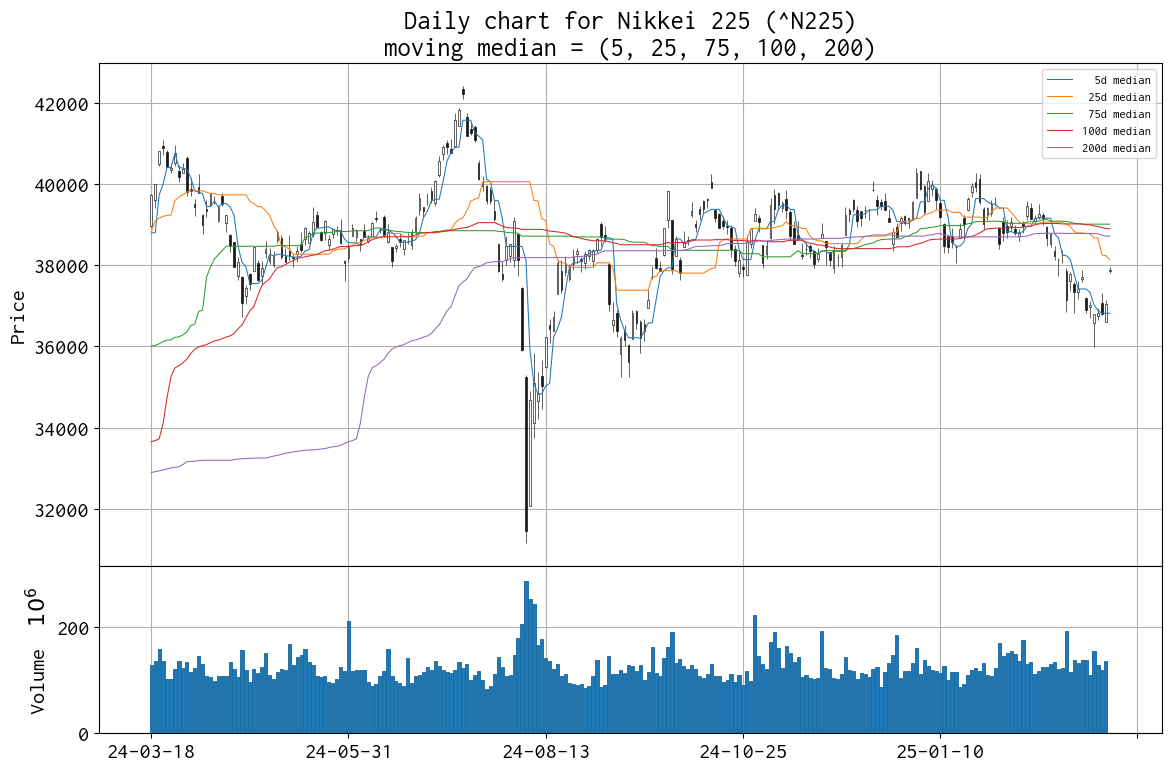

In [4]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig = plt.figure(figsize=(12, 8))
ax = dict()
n = 2
gs = fig.add_gridspec(
    n, 1,
    wspace=0.0, hspace=0.0,
    height_ratios=[3 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex='col')):
    ax[i] = axis
    ax[i].grid()

mm005 = df0['Close'].rolling(5).median()
mm025 = df0['Close'].rolling(25).median()
mm075 = df0['Close'].rolling(75).median()
mm100 = df0['Close'].rolling(100).median()
mm200 = df0['Close'].rolling(200).median()

apds  = [
    mpf.make_addplot(mm005[df.index], width=0.75, label='  5d median', ax=ax[0]),
    mpf.make_addplot(mm025[df.index], width=0.75, label=' 25d median', ax=ax[0]),
    mpf.make_addplot(mm075[df.index], width=0.75, label=' 75d median', ax=ax[0]),
    mpf.make_addplot(mm100[df.index], width=0.75, label='100d median', ax=ax[0]),
    mpf.make_addplot(mm200[df.index], width=0.75, label='200d median', ax=ax[0]),
]   

mpf.plot(
    df, type='candle', style='default',
    volume=ax[1],
    datetime_format='%y-%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax[0],
)
ax[0].set_title('Daily chart for %s (%s)\nmoving median = (5, 25, 75, 100, 200)' %(ticker.info['longName'], symbol))
ax[0].legend(loc='best', fontsize=9)

plt.tight_layout()
plt.savefig('report_daily_chart_median_%s.png' % code)
plt.show()

In [5]:
df.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-03-14 00:00:00+09:00,36606.781250,37154.390625,36594.039062,37053.101562,134800000,0.0,0.0
2025-03-18 00:00:00+09:00,37868.570312,37969.921875,37822.871094,37896.621094,0,0.0,0.0


In [6]:
df.tail(2)['Close']

Date
2025-03-14 00:00:00+09:00    37053.101562
2025-03-18 00:00:00+09:00    37896.621094
Name: Close, dtype: float64

In [7]:
df.tail(2)['Close'].diff()

Date
2025-03-14 00:00:00+09:00           NaN
2025-03-18 00:00:00+09:00    843.519531
Name: Close, dtype: float64

In [8]:
df['Close'].tail(1) - df['Open'].tail(1)

Date
2025-03-18 00:00:00+09:00    28.050781
dtype: float64

In [9]:
df['Close'].rolling(9).median().tail()

Date
2025-03-11 00:00:00+09:00    37331.179688
2025-03-12 00:00:00+09:00    37155.500000
2025-03-13 00:00:00+09:00    37028.269531
2025-03-14 00:00:00+09:00    37028.269531
2025-03-18 00:00:00+09:00    37028.269531
Name: Close, dtype: float64

In [10]:
df['Close'].rolling(13).median().tail()

Date
2025-03-11 00:00:00+09:00    37704.929688
2025-03-12 00:00:00+09:00    37418.238281
2025-03-13 00:00:00+09:00    37331.179688
2025-03-14 00:00:00+09:00    37155.500000
2025-03-18 00:00:00+09:00    37155.500000
Name: Close, dtype: float64

In [11]:
df['Close'].rolling(26).median().tail()

Date
2025-03-11 00:00:00+09:00    38727.490234
2025-03-12 00:00:00+09:00    38599.064453
2025-03-13 00:00:00+09:00    38467.105469
2025-03-14 00:00:00+09:00    38246.980469
2025-03-18 00:00:00+09:00    38190.080078
Name: Close, dtype: float64

In [12]:
df['Close'].rolling(52).median().tail()

Date
2025-03-11 00:00:00+09:00    38990.285156
2025-03-12 00:00:00+09:00    38990.285156
2025-03-13 00:00:00+09:00    38990.285156
2025-03-14 00:00:00+09:00    38933.099609
2025-03-18 00:00:00+09:00    38866.990234
Name: Close, dtype: float64

## Robust Bollinger's bands

In [13]:
period = 20
calc_robust_bollinger(df0, period)
df0

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Median,Q1,Q3,Lower,Upper
Date,,,,,,,,,,,,
2022-03-18 00:00:00+09:00,26649.500000,26862.429688,26592.980469,26827.429688,108200000,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2022-03-22 00:00:00+09:00,27091.320312,27284.470703,27076.330078,27224.109375,98000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2022-03-23 00:00:00+09:00,27606.789062,28056.199219,27604.369141,28040.160156,88200000,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2022-03-24 00:00:00+09:00,27693.769531,28110.390625,27624.619141,28110.390625,71600000,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2022-03-25 00:00:00+09:00,28338.810547,28338.810547,27946.789062,28149.839844,67400000,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-11 00:00:00+09:00,36584.371094,36793.109375,35987.128906,36793.109375,153600000,0.0,0.0,38467.105469,37633.256836,39010.131836,35567.944336,41075.444336
2025-03-12 00:00:00+09:00,36763.101562,36956.328125,36658.859375,36819.089844,128700000,0.0,0.0,38246.980469,37396.473633,39010.131836,34975.986328,41430.619141
2025-03-13 00:00:00+09:00,37081.640625,37326.269531,36776.941406,36790.031250,119300000,0.0,0.0,38190.080078,37287.259766,39010.131836,34702.951660,41594.439941


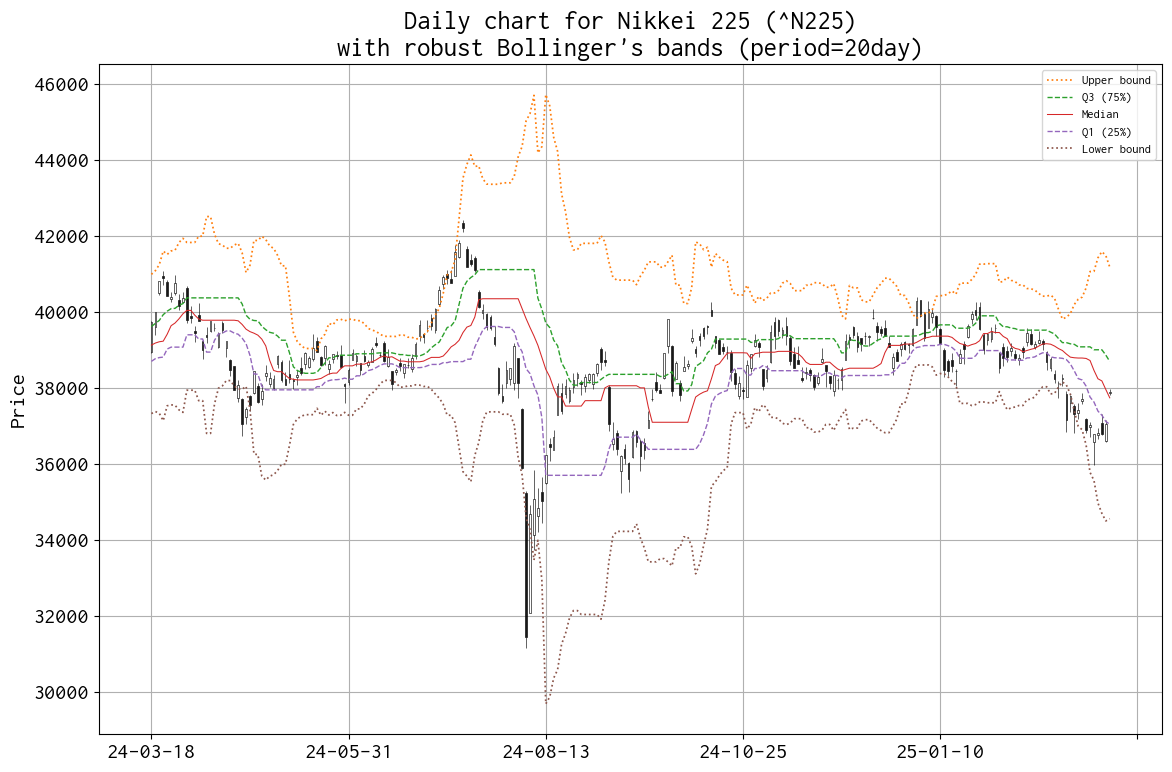

In [14]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 8))

# Bollinger bands
mv_median = df0['Median']
mv_q1 = df0['Q1']
mv_q3 = df0['Q3']
mv_lower = df0['Lower']
mv_upper = df0['Upper']

apds  = [
    mpf.make_addplot(mv_upper[df.index], width=1.25, color='C1', linestyle='dotted', label='Upper bound', ax=ax),
    mpf.make_addplot(mv_q3[df.index], width=1, color='C2', linestyle='dashed', label='Q3 (75%)', ax=ax),
    mpf.make_addplot(mv_median[df.index], width=0.75, color='C3', label='Median', ax=ax),
    mpf.make_addplot(mv_q1[df.index], width=1, color='C4', linestyle='dashed', label='Q1 (25%)', ax=ax),
    mpf.make_addplot(mv_lower[df.index], width=1.25, color='C5', linestyle='dotted', label='Lower bound', ax=ax),
]   

mpf.plot(
    df, type='candle', style='default',
    addplot=apds,
    datetime_format='%y-%m-%d',
    xrotation=0,
    ax=ax,
)

ax.grid()
ax.legend(loc='best', fontsize=9)

try:
    ax.set_title('Daily chart for %s (%s)\nwith robust Bollinger\'s bands (period=%dday)' % (ticker.info['longName'], symbol, period))
except KeyError:
    ax.set_title('Daily chart for %s\nwith robust Bollinger\'s bands (period=%dday)' % (symbol, period))

plt.tight_layout()
plt.savefig('report_daily_chart_bollinger_robust_%s.png' % code)
plt.show()

## ヒストグラム

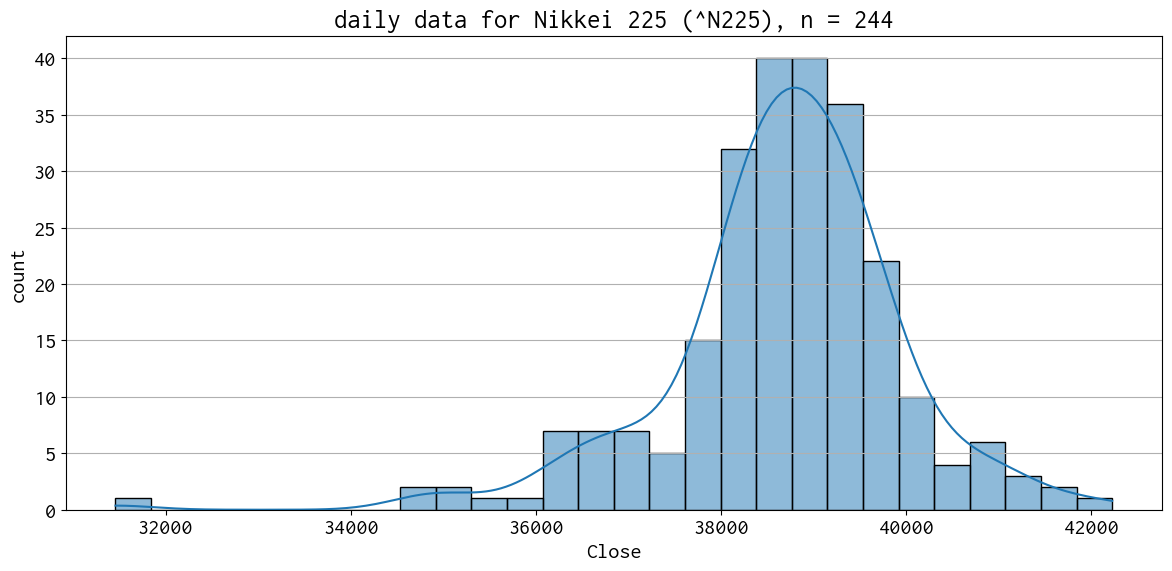

In [15]:
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(12, 6))
#ax = fig.add_axes(111)
ax = fig.add_subplot(111)

sns.histplot(
    df['Close'],
    kde=True,
    ax=ax
)

ax.set_xlabel("Close")
ax.set_ylabel("count")
ax.set_title('daily data for %s (%s), n = %d' % (ticker.info['longName'], symbol, len(df)))
ax.grid(axis = 'y')

plt.tight_layout()
plt.savefig('report_daily_histogram_%s.png' % code)
plt.show()